In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, concatenate, Dense, Flatten, Embedding, Bidirectional, Dropout, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

2024-04-09 17:34:32.298450: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2024-04-09 17:34:34.210178: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2024-04-09 17:34:34.221274: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2024-04-09 17:34:34.750973: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 44 outputs. Output shapes may be inaccurate.
2024-04-09 17:34:36.495000: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 14 outputs but the _ou

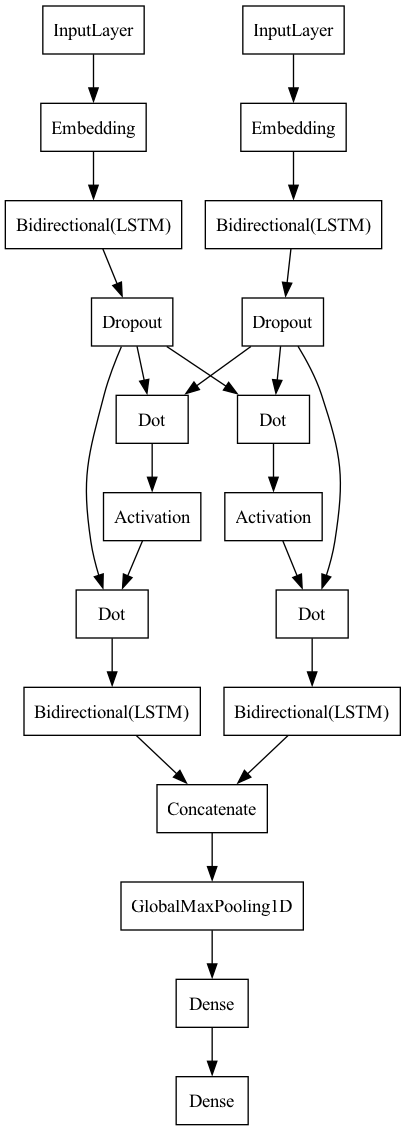

In [105]:
model = tf.keras.models.load_model(f"../saved_models/advanced")
dot_img_file = '/tmp/advanced.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False,show_layer_names=False)

In [26]:
# Import dataset
import pandas as pd
from IPython.display import display
from sklearn.utils import shuffle

df_1 = pd.read_csv(r"training_data/IBM30K_shuffled_n.csv")
df_2 = pd.read_csv(r"training_data/AIFdb_Toni.csv")
df_3 = pd.read_csv(r"training_data/ACM.csv")

df = pd.concat([df_1, df_2, df_3], axis=0)

display(df)
df = shuffle(df).reset_index(drop=True)

attack_count = df[df['relationship'] == "a"].count().iloc[0]
support_count = df[df['relationship'] == "s"].count().iloc[0]
neither_count = df[df['relationship'] == "n"].count().iloc[0]

print(attack_count, support_count, neither_count)

# Split features and labels
X = df[["argument1", "argument2"]].T.reset_index(drop=True).T
y = df[["relationship"]].T.reset_index(drop=True).T

display(X)
display(y)

,Unnamed: 0,argument1,argument2,relationship
0,12014,legalizing the organ trade would make it easie...,We should legalize organ trade,a
1,28303,we should stop urbanization because of the pol...,We should fight urbanization,s
2,10499,it is necessary to provide a safe space for st...,We should abolish safe spaces,a
3,1788,atheism is a concept to adopt because no relig...,We should adopt atheism,s
4,9828,Intelligence tests help people to know recogni...,Intelligence tests bring more harm than good,a
...,...,...,...,...
4053,4053,the only good thing in this movie was dr schul...,you must have bad taste in movies,a
4054,4054,after all the attention and awards etc and an ...,i loved the film and its your opinion if you d...,a
4055,4055,after all the attention and awards etc and an ...,i agree did not like this either in fact i sto...,s
4056,4056,after all the attention and awards etc and an ...,i too was not too crazy about it there was too...,s


28523 28387 28598


,0,1
0,people need the olympic games in order to fund...,We should abolish the Olympic Games
1,foster care homes do not provide the bonding e...,Foster care brings more harm than good
2,whales are beautiful living creatures that hav...,We should ban whaling
3,people today are not affected by what happene...,We should end affirmative action
4,"""it's not true that TRUMP at one time suggeste...","""TRUMP even at one time suggested that he woul..."
...,...,...
85503,Intellectually I rate Farage much higher than ...,"To steal Lib Dem support, UKIP is trying to es..."
85504,A strong UKIP vote suggests there's a lot of t...,The voters have understood that EU membership ...
85505,"""it’s just well yanked back and forth""","""Пожар был следствием поджога"""
85506,and one still wonders why id is considered to ...,behe claims that that is not the sort of proce...


,0
0,a
1,s
2,s
3,s
4,a
...,...
85503,s
85504,s
85505,n
85506,a


In [27]:
# Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split pairs of sentences
sentences_train_1 = X_train[0].to_numpy()
sentences_train_2 = X_train[1].to_numpy()

sentences_test_1 = X_test[0].to_numpy()
sentences_test_2 = X_test[1].to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [28]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# prepare target
le = LabelEncoder()
le.fit(np.ravel(y))
y_train_enc = le.transform(np.ravel(y_train))
y_test_enc = le.transform(np.ravel(y_test))
print(y_test_enc)

# one hot encoded
y_train_enc = to_categorical(y_train_enc)
y_test_enc = to_categorical(y_test_enc)

print(y_train_enc, y_test_enc)

[2 1 2 ... 2 0 0]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]] [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Flatten features for Glove fitting
texts = np.concatenate([X[0], X[1]])

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
# Encode training data
sequences_train_1 = tokenizer.texts_to_sequences(sentences_train_1)
sequences_train_2 = tokenizer.texts_to_sequences(sentences_train_2)

# Encode testing data
sequences_test_1 = tokenizer.texts_to_sequences(sentences_test_1)
sequences_test_2 = tokenizer.texts_to_sequences(sentences_test_2)

# Padding sequences to have the same length
max_len = 50
print(max_len)

padded_sequences_train_1 = pad_sequences(sequences_train_1, maxlen=max_len, padding='post')
padded_sequences_train_2 = pad_sequences(sequences_train_2, maxlen=max_len, padding='post')

padded_sequences_test_1 = pad_sequences(sequences_test_1, maxlen=max_len, padding='post')
padded_sequences_test_2 = pad_sequences(sequences_test_2, maxlen=max_len, padding='post')

tokenizer_json = tokenizer.to_json()
with open('../saved_tokenizers/tokenizer_full.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

50


In [30]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 50, 300)              1783680   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_5 (Embedding)     (None, 50, 300)              1783680   ['input_6[0][0]']       

In [32]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.0001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 136s 270ms/step - loss: 0.9504 - accuracy: 0.5313 - val_loss: 0.8479 - val_accuracy: 0.6191
Epoch 2/50
481/481 [==============================] - 144s 299ms/step - loss: 0.7428 - accuracy: 0.6746 - val_loss: 0.7097 - val_accuracy: 0.6993
Epoch 3/50
481/481 [==============================] - 128s 266ms/step - loss: 0.6181 - accuracy: 0.7415 - val_loss: 0.6455 - val_accuracy: 0.7306
Epoch 4/50
481/481 [==============================] - 98s 205ms/step - loss: 0.5302 - accuracy: 0.7845 - val_loss: 0.6061 - val_accuracy: 0.7430
Epoch 5/50
481/481 [==============================] - 112s 233ms/step - loss: 0.4650 - accuracy: 0.8142 - val_loss: 0.5854 - val_accuracy: 0.7600
Epoch 6/50
481/481 [==============================] - 112s 234ms/step - loss: 0.4091 - accuracy: 0.8391 - val_loss: 0.6089 - val_accuracy: 0.7571
Epoch 7/50
481/481 [==============================] - 118s 246ms/step - loss: 0.3624 - accuracy: 0.8594 - val_loss: 0.6032 - 

In [33]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 21s 18ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      5694
           1       0.83      0.79      0.81      5764
           2       0.75      0.80      0.77      5644

    accuracy                           0.78     17102
   macro avg       0.78      0.78      0.78     17102
weighted avg       0.78      0.78      0.78     17102



In [34]:
results = model.evaluate([padded_sequences_test_1, padded_sequences_test_2], y_test_enc, batch_size=32)
print("test loss, test acc:", results)

535/535 [==============================] - 18s 33ms/step - loss: 0.7033 - accuracy: 0.7805
test loss, test acc: [0.7033442854881287, 0.7804934978485107]


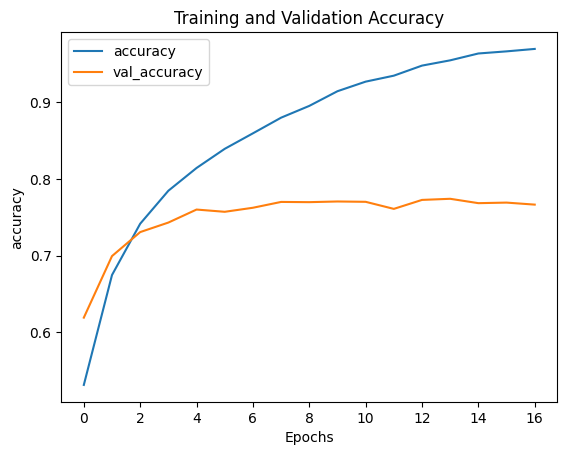

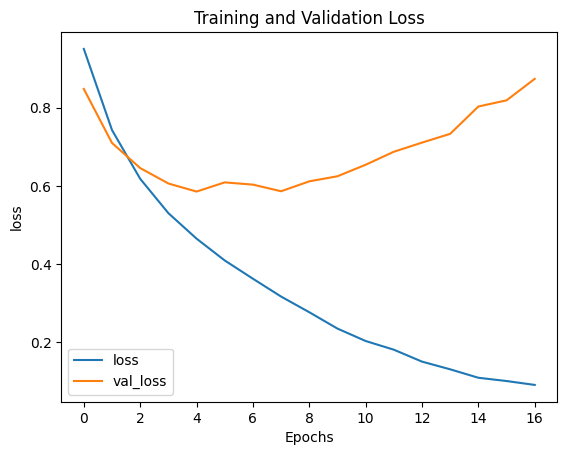

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [36]:
model.save('../saved_models/model_full_v3')

INFO:tensorflow:Assets written to: ../saved_models/model_full_v3/assets


INFO:tensorflow:Assets written to: ../saved_models/model_full_v3/assets


In [37]:
import pickle
with open('tokenizer_model_full_v3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
# BASE MODEL

In [39]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [40]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
base_model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
base_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 100)              5945600   ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 50, 100)              5945600   ['input_8[0][0]']             
                                                                                            

In [41]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = base_model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 19s 32ms/step - loss: 0.9746 - accuracy: 0.5060 - val_loss: 0.8925 - val_accuracy: 0.5832
Epoch 2/50
481/481 [==============================] - 14s 30ms/step - loss: 0.8227 - accuracy: 0.6192 - val_loss: 0.7892 - val_accuracy: 0.6477
Epoch 3/50
481/481 [==============================] - 15s 31ms/step - loss: 0.7397 - accuracy: 0.6729 - val_loss: 0.7256 - val_accuracy: 0.6872
Epoch 4/50
481/481 [==============================] - 15s 31ms/step - loss: 0.6709 - accuracy: 0.7094 - val_loss: 0.6901 - val_accuracy: 0.7038
Epoch 5/50
481/481 [==============================] - 15s 30ms/step - loss: 0.6209 - accuracy: 0.7344 - val_loss: 0.6834 - val_accuracy: 0.7128
Epoch 6/50
481/481 [==============================] - 15s 31ms/step - loss: 0.5828 - accuracy: 0.7549 - val_loss: 0.6543 - val_accuracy: 0.7290
Epoch 7/50
481/481 [==============================] - 15s 30ms/step - loss: 0.5522 - accuracy: 0.7682 - val_loss: 0.6454 - val_accuracy:

In [42]:
from sklearn.metrics import classification_report
y_pred = base_model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 4s 3ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.71      0.74      0.72      5694
           1       0.81      0.74      0.77      5764
           2       0.72      0.75      0.73      5644

    accuracy                           0.74     17102
   macro avg       0.75      0.74      0.74     17102
weighted avg       0.75      0.74      0.74     17102



In [43]:
# BASE MODEL WITH 300D GLOVE

In [44]:
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np
# Load pre-trained GloVe embeddings (you need to download the GloVe file)
glove_embeddings_index = {}
with open('glove/glove.6B.300d.txt', encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs

# Create an embedding matrix using GloVe for words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [45]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=32, return_sequences=True)(emb1)
lstm2 = LSTM(units=32, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 50, 300)              1783680   ['input_9[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_9 (Embedding)     (None, 50, 300)              1783680   ['input_10[0][0]']      

In [46]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 23s 43ms/step - loss: 0.9747 - accuracy: 0.5031 - val_loss: 0.8702 - val_accuracy: 0.5926
Epoch 2/50
481/481 [==============================] - 20s 42ms/step - loss: 0.8049 - accuracy: 0.6417 - val_loss: 0.7694 - val_accuracy: 0.6654
Epoch 3/50
481/481 [==============================] - 20s 41ms/step - loss: 0.6834 - accuracy: 0.7097 - val_loss: 0.7031 - val_accuracy: 0.7017
Epoch 4/50
481/481 [==============================] - 20s 42ms/step - loss: 0.6031 - accuracy: 0.7505 - val_loss: 0.6491 - val_accuracy: 0.7283
Epoch 5/50
481/481 [==============================] - 21s 43ms/step - loss: 0.5422 - accuracy: 0.7778 - val_loss: 0.6507 - val_accuracy: 0.7321
Epoch 6/50
481/481 [==============================] - 21s 44ms/step - loss: 0.4961 - accuracy: 0.7974 - val_loss: 0.6320 - val_accuracy: 0.7474
Epoch 7/50
481/481 [==============================] - 21s 43ms/step - loss: 0.4583 - accuracy: 0.8151 - val_loss: 0.6376 - val_accuracy:

In [47]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 5s 4ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      5694
           1       0.82      0.75      0.78      5764
           2       0.75      0.75      0.75      5644

    accuracy                           0.76     17102
   macro avg       0.76      0.76      0.76     17102
weighted avg       0.76      0.76      0.76     17102



In [48]:
# BASE MODEL WITH 300D GLOVE + 128D LSTM

In [49]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 50, 300)              1783680   ['input_11[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_11 (Embedding)    (None, 50, 300)              1783680   ['input_12[0][0]']      

In [50]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 72s 146ms/step - loss: 0.9405 - accuracy: 0.5310 - val_loss: 0.7881 - val_accuracy: 0.6512
Epoch 2/50
481/481 [==============================] - 70s 146ms/step - loss: 0.6994 - accuracy: 0.6998 - val_loss: 0.6856 - val_accuracy: 0.7138
Epoch 3/50
481/481 [==============================] - 69s 143ms/step - loss: 0.5671 - accuracy: 0.7664 - val_loss: 0.6424 - val_accuracy: 0.7347
Epoch 4/50
481/481 [==============================] - 69s 142ms/step - loss: 0.4727 - accuracy: 0.8104 - val_loss: 0.6348 - val_accuracy: 0.7401
Epoch 5/50
481/481 [==============================] - 69s 143ms/step - loss: 0.3907 - accuracy: 0.8462 - val_loss: 0.6513 - val_accuracy: 0.7497
Epoch 6/50
481/481 [==============================] - 69s 143ms/step - loss: 0.3196 - accuracy: 0.8768 - val_loss: 0.7001 - val_accuracy: 0.7473
Epoch 7/50
481/481 [==============================] - 68s 142ms/step - loss: 0.2604 - accuracy: 0.9023 - val_loss: 0.7513 - val_ac

In [51]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 11s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      5694
           1       0.80      0.73      0.76      5764
           2       0.75      0.73      0.74      5644

    accuracy                           0.75     17102
   macro avg       0.75      0.75      0.75     17102
weighted avg       0.75      0.75      0.75     17102



In [52]:
# BASE MODEL + 300D GLOVE + 128D LSTM + 1DPOOLING & l2

In [53]:
# Create input layers
#input_shape = (50, 100)
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 50, 300)              1783680   ['input_13[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_13 (Embedding)    (None, 50, 300)              1783680   ['input_14[0][0]']      

In [54]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 71s 141ms/step - loss: 1.1117 - accuracy: 0.4763 - val_loss: 0.9854 - val_accuracy: 0.5489
Epoch 2/50
481/481 [==============================] - 68s 141ms/step - loss: 0.8920 - accuracy: 0.6080 - val_loss: 0.8577 - val_accuracy: 0.6391
Epoch 3/50
481/481 [==============================] - 69s 143ms/step - loss: 0.7919 - accuracy: 0.6659 - val_loss: 0.8023 - val_accuracy: 0.6642
Epoch 4/50
481/481 [==============================] - 69s 143ms/step - loss: 0.7379 - accuracy: 0.6995 - val_loss: 0.7779 - val_accuracy: 0.6818
Epoch 5/50
481/481 [==============================] - 69s 143ms/step - loss: 0.6798 - accuracy: 0.7332 - val_loss: 0.7358 - val_accuracy: 0.6989
Epoch 6/50
481/481 [==============================] - 69s 143ms/step - loss: 0.6208 - accuracy: 0.7640 - val_loss: 0.7057 - val_accuracy: 0.7142
Epoch 7/50
481/481 [==============================] - 69s 144ms/step - loss: 0.5701 - accuracy: 0.7878 - val_loss: 0.6964 - val_ac

In [55]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 11s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.69      0.81      0.74      5694
           1       0.84      0.69      0.76      5764
           2       0.75      0.76      0.75      5644

    accuracy                           0.75     17102
   macro avg       0.76      0.75      0.75     17102
weighted avg       0.76      0.75      0.75     17102



In [56]:
# BASE MODEL + 300D GLOVE + 128D BiLSTM

In [57]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 50, 300)              1783680   ['input_15[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_15 (Embedding)    (None, 50, 300)              1783680   ['input_16[0][0]']      

In [58]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 142s 286ms/step - loss: 0.9798 - accuracy: 0.4988 - val_loss: 0.8279 - val_accuracy: 0.6262
Epoch 2/50
481/481 [==============================] - 137s 285ms/step - loss: 0.7139 - accuracy: 0.6903 - val_loss: 0.6962 - val_accuracy: 0.6998
Epoch 3/50
481/481 [==============================] - 138s 286ms/step - loss: 0.5523 - accuracy: 0.7697 - val_loss: 0.6481 - val_accuracy: 0.7285
Epoch 4/50
481/481 [==============================] - 137s 285ms/step - loss: 0.4302 - accuracy: 0.8273 - val_loss: 0.6442 - val_accuracy: 0.7473
Epoch 5/50
481/481 [==============================] - 137s 285ms/step - loss: 0.3314 - accuracy: 0.8716 - val_loss: 0.6958 - val_accuracy: 0.7419
Epoch 6/50
481/481 [==============================] - 137s 285ms/step - loss: 0.2505 - accuracy: 0.9063 - val_loss: 0.7287 - val_accuracy: 0.7493
Epoch 7/50
481/481 [==============================] - 138s 287ms/step - loss: 0.1925 - accuracy: 0.9303 - val_loss: 0.8304 -

In [59]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 19s 17ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      5694
           1       0.79      0.75      0.77      5764
           2       0.76      0.73      0.75      5644

    accuracy                           0.76     17102
   macro avg       0.76      0.76      0.76     17102
weighted avg       0.76      0.76      0.76     17102



In [60]:
# BASE MODEL + 300D GLOVE + 128D LSTM

In [61]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)
#lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
#lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = Flatten()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 50, 300)              1783680   ['input_17[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_17 (Embedding)    (None, 50, 300)              1783680   ['input_18[0][0]']      

In [62]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 73s 145ms/step - loss: 0.9114 - accuracy: 0.5564 - val_loss: 0.7664 - val_accuracy: 0.6721
Epoch 2/50
481/481 [==============================] - 69s 144ms/step - loss: 0.6794 - accuracy: 0.7096 - val_loss: 0.6581 - val_accuracy: 0.7281
Epoch 3/50
481/481 [==============================] - 70s 146ms/step - loss: 0.5581 - accuracy: 0.7686 - val_loss: 0.6345 - val_accuracy: 0.7347
Epoch 4/50
481/481 [==============================] - 70s 146ms/step - loss: 0.4646 - accuracy: 0.8116 - val_loss: 0.6316 - val_accuracy: 0.7471
Epoch 5/50
481/481 [==============================] - 70s 145ms/step - loss: 0.3799 - accuracy: 0.8505 - val_loss: 0.6448 - val_accuracy: 0.7514
Epoch 6/50
481/481 [==============================] - 70s 147ms/step - loss: 0.3078 - accuracy: 0.8829 - val_loss: 0.7032 - val_accuracy: 0.7531
Epoch 7/50
481/481 [==============================] - 69s 144ms/step - loss: 0.2508 - accuracy: 0.9052 - val_loss: 0.7395 - val_ac

In [63]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 11s 10ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5694
           1       0.81      0.74      0.78      5764
           2       0.73      0.78      0.75      5644

    accuracy                           0.76     17102
   macro avg       0.76      0.76      0.76     17102
weighted avg       0.76      0.76      0.76     17102



In [64]:
# Attention upgraded

In [65]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 50, 300)              1783680   ['input_19[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_19 (Embedding)    (None, 50, 300)              1783680   ['input_20[0][0]']      

In [66]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 83s 162ms/step - loss: 0.9824 - accuracy: 0.4906 - val_loss: 0.8847 - val_accuracy: 0.5803
Epoch 2/50
481/481 [==============================] - 78s 161ms/step - loss: 0.7982 - accuracy: 0.6386 - val_loss: 0.7210 - val_accuracy: 0.6946
Epoch 3/50
481/481 [==============================] - 77s 160ms/step - loss: 0.6332 - accuracy: 0.7328 - val_loss: 0.6275 - val_accuracy: 0.7401
Epoch 4/50
481/481 [==============================] - 77s 161ms/step - loss: 0.5215 - accuracy: 0.7855 - val_loss: 0.6106 - val_accuracy: 0.7481
Epoch 5/50
481/481 [==============================] - 78s 161ms/step - loss: 0.4466 - accuracy: 0.8205 - val_loss: 0.6110 - val_accuracy: 0.7566
Epoch 6/50
481/481 [==============================] - 78s 163ms/step - loss: 0.3743 - accuracy: 0.8526 - val_loss: 0.6206 - val_accuracy: 0.7620
Epoch 7/50
481/481 [==============================] - 77s 161ms/step - loss: 0.3138 - accuracy: 0.8790 - val_loss: 0.6579 - val_ac

In [67]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 13s 11ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5694
           1       0.80      0.79      0.80      5764
           2       0.78      0.75      0.77      5644

    accuracy                           0.77     17102
   macro avg       0.77      0.77      0.77     17102
weighted avg       0.77      0.77      0.77     17102



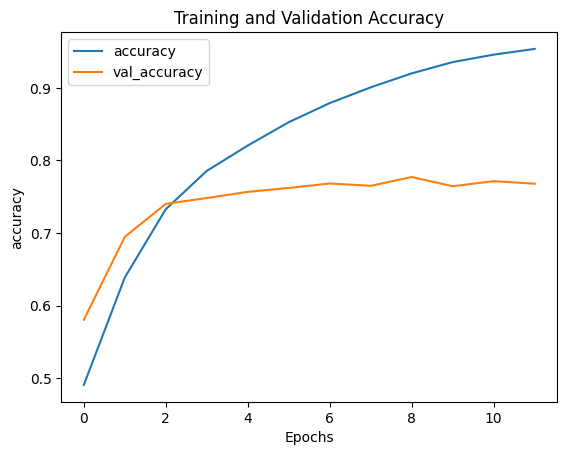

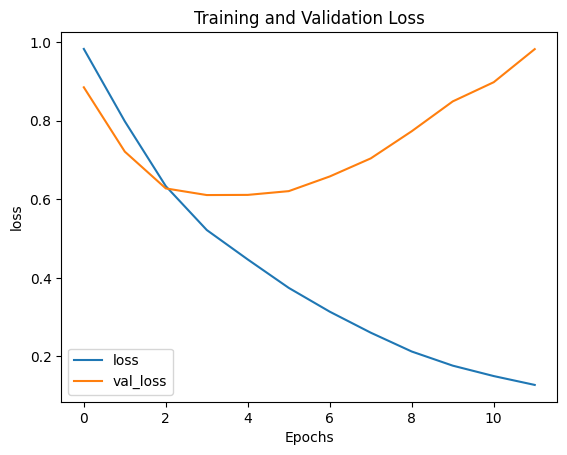

In [68]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [69]:
# Attention + BiLSTM

In [70]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Flatten
from tensorflow.keras.models import Model

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

# Dropouts
dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the attended outputs
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
flat = Flatten()(concatenated)

# Instead of flattening, feed the concatenated attended outputs directly to the dense layer
dense_layer = Dense(32, activation='relu')(flat)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 50, 300)              1783680   ['input_21[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_21 (Embedding)    (None, 50, 300)              1783680   ['input_22[0][0]']     

In [71]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 168s 332ms/step - loss: 0.9290 - accuracy: 0.5457 - val_loss: 0.7867 - val_accuracy: 0.6492
Epoch 2/50
481/481 [==============================] - 155s 322ms/step - loss: 0.6775 - accuracy: 0.7108 - val_loss: 0.6689 - val_accuracy: 0.7183
Epoch 3/50
481/481 [==============================] - 155s 323ms/step - loss: 0.5345 - accuracy: 0.7803 - val_loss: 0.6345 - val_accuracy: 0.7351
Epoch 4/50
481/481 [==============================] - 157s 325ms/step - loss: 0.4210 - accuracy: 0.8307 - val_loss: 0.6464 - val_accuracy: 0.7497
Epoch 5/50
481/481 [==============================] - 156s 325ms/step - loss: 0.3308 - accuracy: 0.8714 - val_loss: 0.6987 - val_accuracy: 0.7427
Epoch 6/50
481/481 [==============================] - 157s 327ms/step - loss: 0.2511 - accuracy: 0.9068 - val_loss: 0.7557 - val_accuracy: 0.7516
Epoch 7/50
481/481 [==============================] - 157s 325ms/step - loss: 0.1968 - accuracy: 0.9295 - val_loss: 0.8529 -

In [72]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 21s 17ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5694
           1       0.78      0.74      0.76      5764
           2       0.76      0.73      0.75      5644

    accuracy                           0.75     17102
   macro avg       0.75      0.75      0.75     17102
weighted avg       0.75      0.75      0.75     17102



In [73]:
# BASE MODEL + 300D GLOVE + 256D BiLSTM + max1DPooling + attention

In [74]:
input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
#lstm1 = LSTM(units=128, return_sequences=True)(emb1)
#lstm2 = LSTM(units=128, return_sequences=True)(emb2)
lstm1 = Bidirectional(LSTM(units=256, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=256, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Concatenate the outputs of both LSTM layers
concatenated = concatenate([dropout1, dropout2], axis=-1)

# Reduce dimensionality while preserving important features
pooled = GlobalMaxPooling1D()(concatenated)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_24 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_22 (Embedding)    (None, 50, 300)              1783680   ['input_23[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_23 (Embedding)    (None, 50, 300)              1783680   ['input_24[0][0]']     

In [75]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - 348s 704ms/step - loss: 0.9426 - accuracy: 0.5306 - val_loss: 0.8044 - val_accuracy: 0.6470
Epoch 2/50
481/481 [==============================] - 333s 693ms/step - loss: 0.6802 - accuracy: 0.7105 - val_loss: 0.6374 - val_accuracy: 0.7383
Epoch 3/50
481/481 [==============================] - 348s 723ms/step - loss: 0.5366 - accuracy: 0.7809 - val_loss: 0.5754 - val_accuracy: 0.7628
Epoch 4/50
481/481 [==============================] - 324s 674ms/step - loss: 0.4416 - accuracy: 0.8227 - val_loss: 0.5622 - val_accuracy: 0.7736
Epoch 5/50
481/481 [==============================] - 324s 674ms/step - loss: 0.3583 - accuracy: 0.8620 - val_loss: 0.5515 - val_accuracy: 0.7761
Epoch 6/50
481/481 [==============================] - 327s 680ms/step - loss: 0.2851 - accuracy: 0.8936 - val_loss: 0.5677 - val_accuracy: 0.7782
Epoch 7/50
481/481 [==============================] - 330s 687ms/step - loss: 0.2286 - accuracy: 0.9163 - val_loss: 0.6295 -

In [76]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

1069/1069 [==============================] - 39s 33ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      5694
           1       0.86      0.77      0.81      5764
           2       0.77      0.79      0.78      5644

    accuracy                           0.79     17102
   macro avg       0.79      0.79      0.79     17102
weighted avg       0.79      0.79      0.79     17102



In [77]:
# Attention P to C

In [78]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=64, return_sequences=True)(emb1)
lstm2 = LSTM(units=64, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=64, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=64, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_25 (Embedding)    (None, 50, 300)              1783680   ['input_26[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_24 (Embedding)    (None, 50, 300)              1783680   ['input_25[0][0]']     

In [79]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - ETA: 0s - loss: 0.9747 - accuracy: 0.5049

W0000 00:00:1712477193.904135       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712477193.904966       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

481/481 [==============================] - 69s 127ms/step - loss: 0.9747 - accuracy: 0.5049 - val_loss: 0.8761 - val_accuracy: 0.5951
Epoch 2/50
481/481 [==============================] - 59s 122ms/step - loss: 0.7946 - accuracy: 0.6471 - val_loss: 0.7273 - val_accuracy: 0.6856
Epoch 3/50
481/481 [==============================] - 59s 122ms/step - loss: 0.6686 - accuracy: 0.7169 - val_loss: 0.6710 - val_accuracy: 0.7141
Epoch 4/50
481/481 [==============================] - 59s 122ms/step - loss: 0.5786 - accuracy: 0.7619 - val_loss: 0.6268 - val_accuracy: 0.7438
Epoch 5/50
481/481 [==============================] - 59s 123ms/step - loss: 0.5048 - accuracy: 0.7957 - val_loss: 0.5960 - val_accuracy: 0.7609
Epoch 6/50
481/481 [==============================] - 58s 122ms/step - loss: 0.4448 - accuracy: 0.8222 - val_loss: 0.5977 - val_accuracy: 0.7671
Epoch 7/50
481/481 [==============================] - 58s 120ms/step - loss: 0.3939 - accuracy: 0.8441 - val_loss: 0.6057 - val_accuracy: 0.7

In [80]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712477956.557330       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712477956.557372       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

1069/1069 [==============================] - 11s 8ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      5694
           1       0.82      0.78      0.80      5764
           2       0.74      0.77      0.76      5644

    accuracy                           0.77     17102
   macro avg       0.77      0.77      0.77     17102
weighted avg       0.77      0.77      0.77     17102



In [81]:
# Attention P to C with 2 LSTM 128

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(lstm1, lstm2)
c_to_p_attended = p_to_c_attention(lstm2, lstm1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_27 (Embedding)    (None, 50, 300)              1783680   ['input_28[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_26 (Embedding)    (None, 50, 300)              1783680   ['input_27[0][0]']     

In [83]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.5085

W0000 00:00:1712478118.544884       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712478118.544929       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

481/481 [==============================] - 154s 307ms/step - loss: 0.9718 - accuracy: 0.5085 - val_loss: 0.8264 - val_accuracy: 0.6237
Epoch 2/50
481/481 [==============================] - 145s 302ms/step - loss: 0.6820 - accuracy: 0.7035 - val_loss: 0.6230 - val_accuracy: 0.7350
Epoch 3/50
481/481 [==============================] - 145s 301ms/step - loss: 0.5214 - accuracy: 0.7823 - val_loss: 0.5559 - val_accuracy: 0.7742
Epoch 4/50
481/481 [==============================] - 146s 303ms/step - loss: 0.4289 - accuracy: 0.8268 - val_loss: 0.5393 - val_accuracy: 0.7815
Epoch 5/50
481/481 [==============================] - 144s 300ms/step - loss: 0.3539 - accuracy: 0.8598 - val_loss: 0.5464 - val_accuracy: 0.7916
Epoch 6/50
481/481 [==============================] - 144s 299ms/step - loss: 0.2934 - accuracy: 0.8845 - val_loss: 0.5714 - val_accuracy: 0.7945
Epoch 7/50
481/481 [==============================] - 144s 299ms/step - loss: 0.2405 - accuracy: 0.9065 - val_loss: 0.6200 - val_accura

In [84]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712479436.938016       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712479436.938076       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

1069/1069 [==============================] - 22s 19ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      5694
           1       0.88      0.79      0.83      5764
           2       0.78      0.78      0.78      5644

    accuracy                           0.80     17102
   macro avg       0.80      0.80      0.80     17102
weighted avg       0.80      0.80      0.80     17102



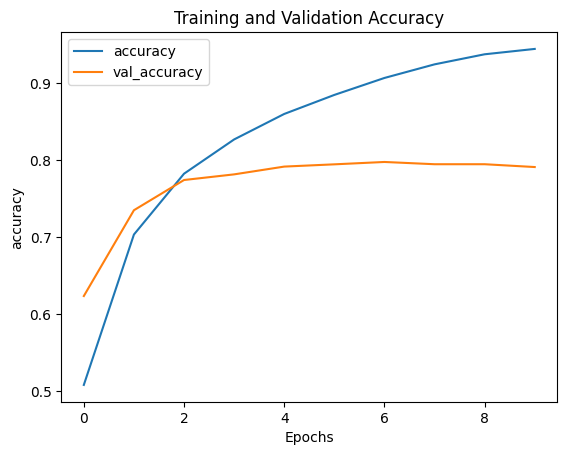

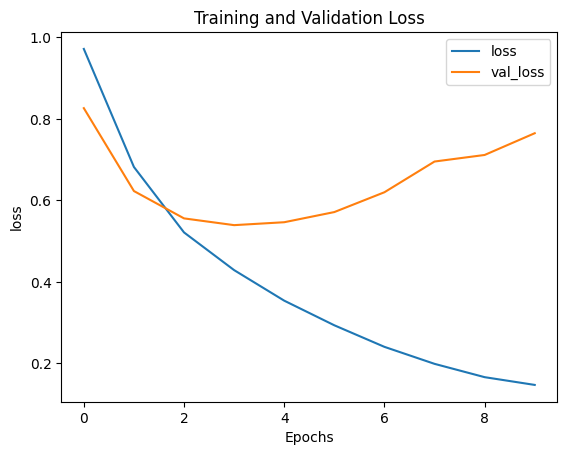

In [85]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.title('Training and Validation ' + metric.capitalize())
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [86]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_29 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 50, 300)              1783680   ['input_30[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_28 (Embedding)    (None, 50, 300)              1783680   ['input_29[0][0]']     

In [87]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.001,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

Epoch 1/50
481/481 [==============================] - ETA: 0s - loss: 0.9700 - accuracy: 0.5077

W0000 00:00:1712479799.345119       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712479799.345160       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

481/481 [==============================] - 350s 699ms/step - loss: 0.9700 - accuracy: 0.5077 - val_loss: 0.8250 - val_accuracy: 0.6227
Epoch 2/50
481/481 [==============================] - 332s 691ms/step - loss: 0.7248 - accuracy: 0.6793 - val_loss: 0.6314 - val_accuracy: 0.7328
Epoch 3/50
481/481 [==============================] - 324s 675ms/step - loss: 0.5646 - accuracy: 0.7613 - val_loss: 0.5557 - val_accuracy: 0.7658
Epoch 4/50
481/481 [==============================] - 327s 680ms/step - loss: 0.4783 - accuracy: 0.8034 - val_loss: 0.5271 - val_accuracy: 0.7810
Epoch 5/50
481/481 [==============================] - 328s 682ms/step - loss: 0.4136 - accuracy: 0.8326 - val_loss: 0.5120 - val_accuracy: 0.7897
Epoch 6/50
481/481 [==============================] - 333s 692ms/step - loss: 0.3584 - accuracy: 0.8572 - val_loss: 0.5071 - val_accuracy: 0.7924
Epoch 7/50
481/481 [==============================] - 330s 686ms/step - loss: 0.3100 - accuracy: 0.8777 - val_loss: 0.5167 - val_accura

In [88]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

W0000 00:00:1712486670.875563       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712486670.875629       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

1069/1069 [==============================] - 686s 121ms/step
{'a': 0, 'n': 1, 's': 2}
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      5694
           1       0.89      0.80      0.84      5764
           2       0.80      0.79      0.79      5644

    accuracy                           0.80     17102
   macro avg       0.81      0.80      0.80     17102
weighted avg       0.81      0.80      0.80     17102



Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_41 (Embedding)    (None, 50, 300)              4146300   ['input_42[0][0]']            
                                                                                                  
 embedding_40 (Embedding)    (None, 50, 300)              4146300   ['input_41[0][0]']            
                                                                                           

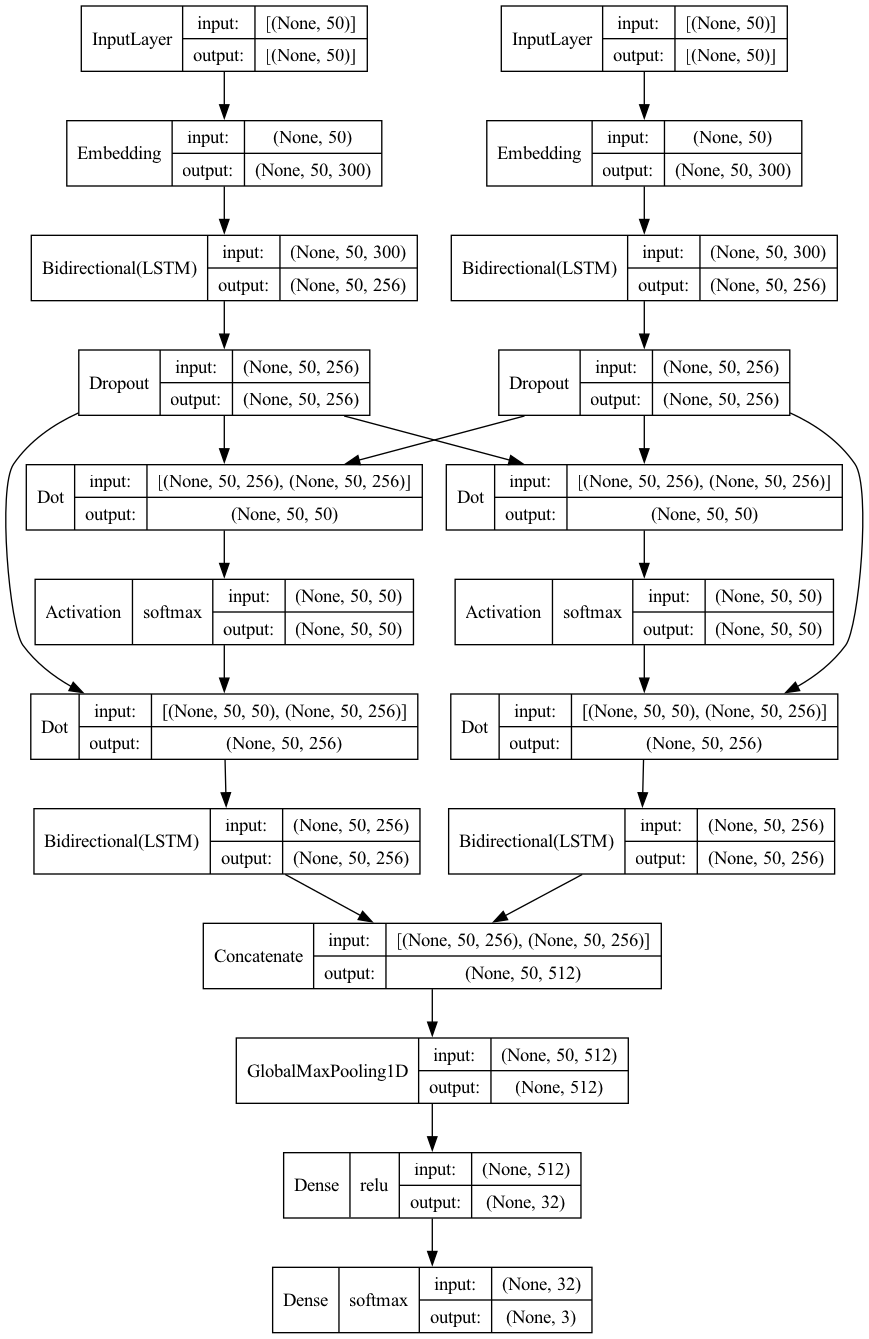

In [83]:
# Show the model architecture
model.summary()
tf.keras.utils.plot_model(model, show_layer_activations=True, show_layer_names=False, show_shapes=True, expand_nested=False)

In [89]:
model.save('../saved_models/full_model_final')

INFO:tensorflow:Assets written to: ../saved_models/full_model_final/assets


INFO:tensorflow:Assets written to: ../saved_models/full_model_final/assets


In [90]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = LSTM(units=128, return_sequences=True)(emb1)
lstm2 = LSTM(units=128, return_sequences=True)(emb2)

dropout1 = Dropout(0.5)(lstm1)
dropout2 = Dropout(0.5)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = LSTM(units=128, return_sequences=True)(p_to_c_attended)
lstm4 = LSTM(units=128, return_sequences=True)(c_to_p_attended)

dropout3 = Dropout(0.5)(lstm3)
dropout4 = Dropout(0.5)(lstm4)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([dropout3, dropout4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_31 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 embedding_31 (Embedding)    (None, 50, 300)              1783680   ['input_32[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_30 (Embedding)    (None, 50, 300)              1783680   ['input_31[0][0]']     

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

Epoch 1/10
481/481 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.5104

W0000 00:00:1712487557.105689       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1712487557.105842       1 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } enviro

481/481 [==============================] - 566s 1s/step - loss: 1.0460 - accuracy: 0.5104 - val_loss: 0.9728 - val_accuracy: 0.5797
Epoch 2/10
481/481 [==============================] - 513s 1s/step - loss: 0.8633 - accuracy: 0.6154 - val_loss: 0.9061 - val_accuracy: 0.6259
Epoch 3/10
481/481 [==============================] - 510s 1s/step - loss: 0.7717 - accuracy: 0.6716 - val_loss: 0.8449 - val_accuracy: 0.6679
Epoch 4/10
481/481 [==============================] - 1089s 2s/step - loss: 0.6833 - accuracy: 0.7211 - val_loss: 0.7902 - val_accuracy: 0.6980
Epoch 5/10
285/481 [================>.............] - ETA: 3:17 - loss: 0.6177 - accuracy: 0.7550

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, Permute, Reshape, Dot, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the P to C attention mechanism
def p_to_c_attention(child, parent):
    # Step 1: Dot product between parent and child sequences to get the attention scores
    attention_scores = Dot(axes=[2, 2])([parent, child])
    
    # Step 2: Apply softmax to get attention distribution
    attention_distribution = Activation('softmax')(attention_scores)
    
    # Step 3: Use the attention distribution to compute weighted sum of parent sequences
    weighted_sum = Dot(axes=[1, 1])([attention_distribution, parent])
    
    return weighted_sum

input_shape = (max_len,)
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

# Create Embedding layer
emb1 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input1)
emb2 = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True)(input2)

# Create LSTM layers
lstm1 = Bidirectional(LSTM(units=128, return_sequences=True))(emb1)
lstm2 = Bidirectional(LSTM(units=128, return_sequences=True))(emb2)

dropout1 = Dropout(0.2)(lstm1)
dropout2 = Dropout(0.2)(lstm2)

# Apply P to C attention
p_to_c_attended = p_to_c_attention(dropout1, dropout2)
c_to_p_attended = p_to_c_attention(dropout2, dropout1)

# Create LSTM layers
lstm3 = Bidirectional(LSTM(units=128, return_sequences=True))(p_to_c_attended)
lstm4 = Bidirectional(LSTM(units=128, return_sequences=True))(c_to_p_attended)

# Optionally combine attended output with the original child sequence
combined_sequence = concatenate([lstm3, lstm4])

# Continue with model construction
pooled = GlobalMaxPooling1D()(combined_sequence)

# Add a Dense layer for further processing
dense_layer = Dense(32, activation='relu')(pooled)

# Add an output layer
output = Dense(3, activation='softmax')(dense_layer)

# Create the model
model = Model(inputs=[input1, input2], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max', 
    min_delta=0.01,
    patience=1,
    restore_best_weights=True,
)

history = model.fit(
    [padded_sequences_train_1, padded_sequences_train_2], 
    y=y_train_enc, 
    validation_split=0.1,
    batch_size=128,
    epochs=10,
    verbose=1,
    callbacks=[es]
)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict([padded_sequences_test_1, padded_sequences_test_2], batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

print(classification_report(np.argmax(y_test_enc,axis=1), y_pred_bool))